# Chapter 6 - Linear Model Selection and Regularization

The following exercises, code, and explanations are adapted from An Introduction to Statistical Learning with Applications in Python (ISLP) (James, Witten, Hastie, Tibshirani, and Taylor 2023).

Make sure the following packages are installed prior to running code in this notebook:
- `numpy`
- `pandas`
- `matplotlib`
- `sklearn`
- `itertools`
- `os`
- `warnings`

### 1) Import Packages 
Please note that the example below focuses on the more applied side of the chapter. Below example primarily comes from Exercise #8 as shown in the textbook, but with minor modifications that include all parts of the model selection covered in this chapter.

In [41]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import itertools

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
import warnings
warnings.filterwarnings('ignore') 

Before we start our analysis, let's begin by defining several user-defined functions for model selection.
### (1) Best Subset Selection

In [42]:
# Determines best model of size K
# y is a vector for the dependent variable (response)
# X is a dataframe with each column representing a different independent variable (predictors)
# K = number of features
def bestModel(y, X, K):
    results = []
    results2 = []

    # gets RSS for each K combo of variables from X
    for c in itertools.combinations(X.columns, K):
        results.append(getRSS(y, X, c))

    for c in itertools.combinations(X.columns, K):
        results2.append(getRSS(y, X, c))

    model_all = pd.DataFrame(results)
    best_model = model_all.iloc[model_all["RSS"].astype('float64').idxmin()]
    return best_model

### (2) Forward Selection

In [43]:
# Performs forward stepwise regression, stores and returns results from each step in a dataframe
# y is a vector for the dependent variable (response)
# X is a dataframe with each column representing a different independent variable (predictors)
def forward_stepwise(y, X):
    results = []
    columns = X.columns.values
    currentVars = []
    for i in range(len(X.columns)):
        resultsTemp = []
        for newVariable in columns:
            model = getRSS(y, X, currentVars + [newVariable])
            model.update({'var': newVariable})
            resultsTemp.append(model)
        current_models = pd.DataFrame(resultsTemp)
        bestNewVariable = current_models.loc[current_models["RSS"].astype('float64').idxmin(), 'var']
        currentVars.append(bestNewVariable)
        results.append(current_models.iloc[current_models["RSS"].astype('float64').idxmin()])
        columns = np.delete(columns, np.argwhere(columns == bestNewVariable))
    return pd.DataFrame(results).reset_index()

### (3) Backward Selection

In [44]:
#Performs backward stepwise regression, stores and returns results from each step in a dataframe
# y is a vector for the dependent variable (response)
# X is a dataframe with each column representing a different independent variable (predictors)
def backward_stepwise(y, X):
    results = []
    currentVars = X.columns.values

    fullModel = getRSS(y, X, X.columns)
    fullModel.update({'var': 'n/a'})
    results.insert(0, pd.DataFrame([fullModel, fullModel]).iloc[
        0])  # necessary to wrap it as a DataFrame row so it plays nice with the return statement
    for i in range(len(X.columns) - 1):
        resultsTemp = []
        for newVariable in currentVars:
            newVars = currentVars[np.where(currentVars != newVariable)]
            model = getRSS(y, X, newVars)
            model.update({'var': newVariable})
            resultsTemp.append(model)
        current_models = pd.DataFrame(resultsTemp)
        bestNewVariable = current_models.loc[current_models["RSS"].astype('float64').idxmin(), 'var']
        currentVars = currentVars[np.where(currentVars != bestNewVariable)]
        results.insert(0, current_models.iloc[current_models["RSS"].astype('float64').idxmin()])
    return pd.DataFrame(results).reset_index()

### (4) Output Model Score

In [45]:
def getRSS(y, X, feature_list):
    model = linear_model.LinearRegression().fit(X[list(feature_list)], y)
    predict = model.predict(X[list(feature_list)])
    RSS = ((predict - y) ** 2).sum()
    return {'Features': feature_list, 'Model': model, "RSS": RSS.astype('float64'),
            'R^2': model.score(X[list(feature_list)], y)}

(a) Creat a random number and use its `normal( )` method to generate a predictor $X$ of length $n = 100$, as well as a noise vector $\epsilon$ of length $n = 100$.

Note that We begin by creating our simulated dataset.

In [46]:
np.random.seed(921101) #set seeds
X = pd.DataFrame(np.random.normal(size=100), columns=["1"])
# Generate random errors from standard normal
epsilon = pd.DataFrame(np.random.normal(size=100, scale=5), columns=["1"])

In [47]:
X.head(10)

,1
0,-1.634182
1,-1.176689
2,0.254375
3,-0.063418
4,-0.684624
5,0.268141
6,0.090110
7,0.666177
8,-1.056040
9,0.127226


In [48]:
epsilon.head(10)

,1
0,2.730751
1,-4.376324
2,-5.126164
3,-5.217158
4,-2.300488
5,0.738908
6,2.074685
7,-9.858959
8,3.277119
9,4.665374


(b) Generate a response vector $Y$ of length $n = 100$ according to the model 
$$Y=\beta_{0}+\beta_{1}X+\beta_{2}X^2+\beta_{3}X^3+\epsilon,$$
where $\beta_{0}$, $\beta_{1}$, $\beta_{2}$ and $\beta_{3}$ are constant or your choice.

Here, based on the above requirement, we set all coefficients to be the value of 5.

In [49]:
y = X.applymap(lambda x: (5 + 5 * x + 5 * (x ** 2) + 5 * (x ** 3)))  # Transforms X to y using an inline function
y = y + epsilon  # Adds normally distributed noise (error term)

In [50]:
y.head(10)

,1
0,-8.908230
1,-6.482984
2,1.551547
3,-0.515412
4,0.015491
5,7.535504
6,7.569490
7,2.169109
8,2.684430
9,10.392732


(c) Use Best subset selection to select a model containing $X$, $X^2$ $\dots$ $X^{10}$. What is the model according to $C_{p}$? Report the coefficents of the model obtained.

In [51]:
# Adds columns to X (data frame): X^2, X^3, ..., X^10
for i in range(2, 11):
    X.insert(loc=i - 1, column=str(i), value=X.iloc[:, 0] ** i)


#need to rename the column names of X first
dict = {'1': 'X1',
        '2': 'X2',
        '3': 'X3',
        '4': 'X4',
        '5': 'X5',
        '6': 'X6',
        '7': 'X7',
        '8': 'X8',
        '9': 'X9',
        '10': 'X10',}
 
# call rename () method
X.rename(columns=dict,
          inplace=True)
print(X)

          X1        X2         X3         X4          X5            X6  \
0  -1.634182  2.670550  -4.364165   7.131839  -11.654721  1.904593e+01   
1  -1.176689  1.384597  -1.629240   1.917109   -2.255841  2.654423e+00   
2   0.254375  0.064707   0.016460   0.004187    0.001065  2.709259e-04   
3  -0.063418  0.004022  -0.000255   0.000016   -0.000001  6.505213e-08   
4  -0.684624  0.468710  -0.320890   0.219689   -0.150404  1.029705e-01   
..       ...       ...        ...        ...         ...           ...   
95 -1.288776  1.660944  -2.140584   2.758734   -3.555390  4.582101e+00   
96 -1.079471  1.165258  -1.257862   1.357826   -1.465733  1.582217e+00   
97  2.761383  7.625237  21.056203  58.144246  160.558547  4.433637e+02   
98  0.597858  0.357434   0.213695   0.127759    0.076382  4.566544e-02   
99 -0.722149  0.521499  -0.376600   0.271961   -0.196396  1.418273e-01   

              X7            X8            X9           X10  
0  -3.112452e+01  5.086312e+01 -8.311959e+01  1.35

In [52]:
# Constructs empty data frame with just column headers
models_bestsub = pd.DataFrame(columns=["RSS", "Model", "var_count", "R^2", "Features"])

# Determines and stores the best model for each number of variables
# ie: first iteration finds the best model with just 1 variable
for i in range(1, (len(X.columns)) + 1):
    models_bestsub.loc[i] = bestModel(y, X, i)
    models_bestsub.loc[i, 'var_count'] = i

# Calculates sigma squared (estimated variance) for each model
m = len(y)
p = 10
hat_sigma_squared = (1 / (m - p - 1)) * models_bestsub['RSS'].iloc[len(models_bestsub) - 1]

# Manually calculates mallow's cp, BIC, and adjusted R squared
models_bestsub['C_p'] = (1 / m) * (
            models_bestsub['var_count'].map(lambda x: (2 * x * hat_sigma_squared)) + models_bestsub['RSS'])
models_bestsub['BIC'] = (
            models_bestsub['RSS'] + np.log(m) * models_bestsub['var_count'].map(lambda x: x * hat_sigma_squared)) \
    .map(lambda x: x / (m * hat_sigma_squared))
models_bestsub['adj_R^2'] = 1 - ((1 - models_bestsub['R^2']) * (m - 1) / (m - models_bestsub['var_count'] - 1))

In [53]:
# Determines best model based on Mallow's Cp
best_model_bestsub = models_bestsub.loc[models_bestsub['C_p'].astype('float64').idxmin(), "Model"]
best_features_bestsub = models_bestsub.loc[models_bestsub['C_p'].astype('float64').idxmin(), "Features"]

In [54]:
#rename the outputs
output_var = str(best_features_bestsub)
temp = output_var.replace("2", "X2")
output = temp.replace("3", "X3")
print(output)

('X1', 'XX3', 'X4', 'X6', 'X9')


In [58]:
#print the outputs
print("The best subsets model has features " + str(
    output) + " based on Mallow's Cp with coefficients " + str(best_model_bestsub.coef_))

The best subsets model has features ('X1', 'XX3', 'X4', 'X6', 'X9') based on Mallow's Cp with coefficients [[ 3.87366869  5.29314967  3.81461332 -0.68309236  0.01247022]]


(d1) Repeat (c) using backward stepwise selection. How does your answer compare to the results in (c)?

In [59]:
#generate the same dataset we need in (c) as we set the same seeds
np.random.seed(78691) #set seeds
X = pd.DataFrame(np.random.normal(size=100), columns=["1"])
# Generate random errors from standard normal
epsilon = pd.DataFrame(np.random.normal(size=100, scale=5), columns=["1"])
epsilon.head(5)

,1
0,-2.766747
1,2.871598
2,-10.039232
3,-4.961581
4,3.106835


In [60]:
y = X.applymap(lambda x: (5 + 5 * x + 5 * (x ** 2) + 5 * (x ** 3)))  # Transforms X to y using an inline function
y = y + epsilon

In [61]:
# Adds columns to X (data frame): X^2, X^3, ..., X^10
for i in range(2, 11):
    X.insert(loc=i - 1, column=str(i), value=X.iloc[:, 0] ** i)
#need to rename the column names of X first
dict = {'1': 'X1',
        '2': 'X2',
        '3': 'X3',
        '4': 'X4',
        '5': 'X5',
        '6': 'X6',
        '7': 'X7',
        '8': 'X8',
        '9': 'X9',
        '10': 'X10',}
 
# call rename () method
X.rename(columns=dict,
          inplace=True)

In [62]:
print(X)

          X1        X2        X3        X4        X5        X6        X7  \
0   1.339657  1.794682  2.404259  3.220884  4.314881  5.780462  7.743839   
1  -0.414241  0.171596 -0.071082  0.029445 -0.012197  0.005053 -0.002093   
2   0.422309  0.178344  0.075316  0.031807  0.013432  0.005673  0.002396   
3   1.345551  1.810508  2.436131  3.277940  4.410636  5.934737  7.985492   
4   0.303994  0.092412  0.028093  0.008540  0.002596  0.000789  0.000240   
..       ...       ...       ...       ...       ...       ...       ...   
95 -0.764707  0.584777 -0.447183  0.341964 -0.261502  0.199973 -0.152920   
96  0.269262  0.072502  0.019522  0.005257  0.001415  0.000381  0.000103   
97 -0.262734  0.069029 -0.018136  0.004765 -0.001252  0.000329 -0.000086   
98 -0.247465  0.061239 -0.015155  0.003750 -0.000928  0.000230 -0.000057   
99  0.258374  0.066757  0.017248  0.004457  0.001151  0.000298  0.000077   

           X8         X9           X10  
0   10.374092  13.897729  1.861820e+01  
1    

In [63]:
# Performs backward stepwise regression and stores results from each step in a dataframe
models_backward = backward_stepwise(y, X)

In [64]:
# Adds column to models dataframe indicating number of variables in each model
models_backward['var_count'] = range(1, 11)
# Manually calculates Cp, BIC, and adjusted R squared and adds each as a column to the models dataframe
models_backward['C_p'] = (1 / m) * (
            models_backward['var_count'].map(lambda x: (2 * x * hat_sigma_squared)) + models_backward['RSS'])
models_backward['BIC'] = (
            models_backward['RSS'] + np.log(m) * models_backward['var_count'].map(lambda x: x * hat_sigma_squared)) \
    .map(lambda x: x / (m * hat_sigma_squared))
models_backward['adj_R^2'] = 1 - ((1 - models_backward['R^2']) * (m - 1) / (m - models_backward['var_count'] - 1))

In [65]:
# Determines best model based on Mallow's Cp
best_model_backward = models_backward.loc[models_backward['C_p'].astype('float64').idxmin(), "Model"]
best_features_backward = models_backward.loc[models_backward['C_p'].astype('float64').idxmin(), "Features"]

In [66]:
#rename the outputs
output_var = str(best_features_backward)
print(output_var)
temp = output_var.replace("2", "X2")
output = temp.replace("3", "X3")
print(output)

['X1' 'X2' 'X3']
['X1' 'XX2' 'XX3']


In [67]:
##print the outputs
print("The backward stepwise model has features " + str(
    output) + " based on Mallow's Cp with coefficients " + str(best_model_backward.coef_))

The backward stepwise model has features ['X1' 'XX2' 'XX3'] based on Mallow's Cp with coefficients [[5.84127514 4.43649372 4.7826633 ]]


(d2) Repeat (c) using forward stepwise selection. How does your answer compare to the results in (c)?

In [68]:
#generate the same dataset we need in (c) as we set the same seeds
np.random.seed(78691) #set seeds
X = pd.DataFrame(np.random.normal(size=100), columns=["1"])
# Generate random errors from standard normal
epsilon = pd.DataFrame(np.random.normal(size=100, scale=5), columns=["1"])
epsilon.head(5)

,1
0,-2.766747
1,2.871598
2,-10.039232
3,-4.961581
4,3.106835


In [69]:
y = X.applymap(lambda x: (5 + 5 * x + 5 * (x ** 2) + 5 * (x ** 3)))  # Transforms X to y using an inline function
y = y + epsilon

In [70]:
# Adds columns to X (data frame): X^2, X^3, ..., X^10
for i in range(2, 11):
    X.insert(loc=i - 1, column=str(i), value=X.iloc[:, 0] ** i)
#need to rename the column names of X first
dict = {'1': 'X1',
        '2': 'X2',
        '3': 'X3',
        '4': 'X4',
        '5': 'X5',
        '6': 'X6',
        '7': 'X7',
        '8': 'X8',
        '9': 'X9',
        '10': 'X10',}
 
# call rename () method
X.rename(columns=dict,
          inplace=True)

In [71]:
print(X)

          X1        X2        X3        X4        X5        X6        X7  \
0   1.339657  1.794682  2.404259  3.220884  4.314881  5.780462  7.743839   
1  -0.414241  0.171596 -0.071082  0.029445 -0.012197  0.005053 -0.002093   
2   0.422309  0.178344  0.075316  0.031807  0.013432  0.005673  0.002396   
3   1.345551  1.810508  2.436131  3.277940  4.410636  5.934737  7.985492   
4   0.303994  0.092412  0.028093  0.008540  0.002596  0.000789  0.000240   
..       ...       ...       ...       ...       ...       ...       ...   
95 -0.764707  0.584777 -0.447183  0.341964 -0.261502  0.199973 -0.152920   
96  0.269262  0.072502  0.019522  0.005257  0.001415  0.000381  0.000103   
97 -0.262734  0.069029 -0.018136  0.004765 -0.001252  0.000329 -0.000086   
98 -0.247465  0.061239 -0.015155  0.003750 -0.000928  0.000230 -0.000057   
99  0.258374  0.066757  0.017248  0.004457  0.001151  0.000298  0.000077   

           X8         X9           X10  
0   10.374092  13.897729  1.861820e+01  
1    

In [72]:
# Performs backward stepwise regression and stores results from each step in a dataframe
models_forward = forward_stepwise(y, X)

In [73]:
# Adds column to models dataframe indicating number of variables in each model
models_forward['var_count'] = range(1, 11)
# Manually calculates Cp, BIC, and adjusted R squared and adds each as a column to the models dataframe
models_forward['C_p'] = (1 / m) * (
            models_forward['var_count'].map(lambda x: (2 * x * hat_sigma_squared)) + models_backward['RSS'])
models_forward['BIC'] = (
            models_forward['RSS'] + np.log(m) * models_forward['var_count'].map(lambda x: x * hat_sigma_squared)) \
    .map(lambda x: x / (m * hat_sigma_squared))
models_forward['adj_R^2'] = 1 - ((1 - models_forward['R^2']) * (m - 1) / (m - models_forward['var_count'] - 1))

In [74]:
# Determines best model based on Mallow's Cp
best_model_forward = models_forward.loc[models_forward['C_p'].astype('float64').idxmin(), "Model"]
best_features_forward = models_forward.loc[models_forward['C_p'].astype('float64').idxmin(), "Features"]

In [75]:
#rename the outputs
output_var = str(best_features_forward)
print(output_var)
temp = output_var.replace("2", "X2")
output = temp.replace("3", "X3")
print(output)

['X3', 'X2', 'X1']
['XX3', 'XX2', 'X1']


In [77]:
# Determines best model based on Mallow's Cp
best_model_forward = models_forward.loc[models_forward['C_p'].astype('float64').idxmin(), "Model"]
best_features_forward = models_forward.loc[models_forward['C_p'].astype('float64').idxmin(), "Features"]

In [78]:
##print the outputs
print("The forward stepwise model has features " + str(
    output) + " based on Mallow's Cp with coefficients " + str(best_model_forward.coef_))

The forward stepwise model has features ['XX3', 'XX2', 'X1'] based on Mallow's Cp with coefficients [[4.7826633  4.43649372 5.84127514]]


(e) Now fit a Lasso model to the simulated data, again using $X$, $X^2$ $\dots$ $X^{10}$ as predictors. Use cross-validation to select the optimal value of $\lambda$. Create plots of the cross-validation error as a function of $\lambda$. Report the resulting coefficient estimates, and discuss the results obtained.

In [26]:
# Redefine Lasso function from linear_model package as "lasso" for easier use
lasso = linear_model.Lasso(max_iter=10000)

In [27]:
# Defines a grid of lambdas (penalty terms) from which we'll select an optimal value
lambdas = 10 ** np.linspace(-2, 3, 100)

In [28]:
# Function to split data into training and test sets
# Only makes one split, need to use this function k times to get all k splits
# dataset = dataset you want to split into training and test sets
# k = number of folds for k-fold CV
# index = the iteration of splitting currently being done
# ie: if performing 10-fold CV, first split corresponds to index = 1,last split corresponds to index = 10
def KFCVSplit(dataset, k, index):
    assert (0 <= index and index < k)
    firstSplitIndex = int(len(dataset) * index / k)
    secondSplitIndex = int(len(dataset) * (index + 1) / k)
    trainSet = dataset.drop(range(firstSplitIndex, secondSplitIndex))
    testSet = dataset.iloc[firstSplitIndex:secondSplitIndex]
    return trainSet.reset_index(drop=True), testSet.reset_index(drop=True)

In [29]:
# Constructs empty list in preparation for future MSE values
MSE = []

# This loop performs Lasso with cross-validation for each lambda in our grid defined above
for l in lambdas:
    # Note: The linear_model.Lasso function calls penalty term lambda "alpha"
    # We call the penalty term "lambda" in the slides and when we defines the grid above.
    lasso.set_params(alpha=l)
    currentLambdaMSE = []
    # This loop splits the data into training and test sets
    # Each iteration performs one split of 10-fold CV
    # currentLambdaMSE stores the MSE for each split for the current lambda
    for i in range(10):
        _X_train, _X_test = KFCVSplit(X, 10, i)
        _y_train, _y_test = KFCVSplit(y, 10, i)
        lasso.fit(_X_train, _y_train)
        currentLambdaMSE.append(mean_squared_error(lasso.predict(_X_test), _y_test))
    # Average the MSEs for each split
    MSE.append(np.mean(currentLambdaMSE))

MSEDF = pd.DataFrame(MSE)
print(MSEDF)

              0
0     82.611257
1     81.636881
2     80.448266
3     79.154827
4     77.765169
..          ...
95  1553.356060
96  1509.498763
97  1463.850773
98  1417.008073
99  1369.958005

[100 rows x 1 columns]


In [30]:
# Determines the lambda which produced the smallest average MSE - this is the optimal lambda
minLambda = lambdas[MSEDF.idxmin()][0]

# Sets penalty term to the optimal lambda and performs lasso on the entire dataset
lasso.set_params(alpha=minLambda)
lasso.fit(X, y)
#print the outputs
print("Lasso parameters (in order of ascending power of X): " + str(lasso.coef_))

Lasso parameters (in order of ascending power of X): [ 6.15328299  1.11076814  2.44368766  1.22148562  1.15349922 -0.03353761
 -0.09842299 -0.04326817 -0.00863505  0.00687234]


Text(0, 0.5, 'Cross-validated MSE')

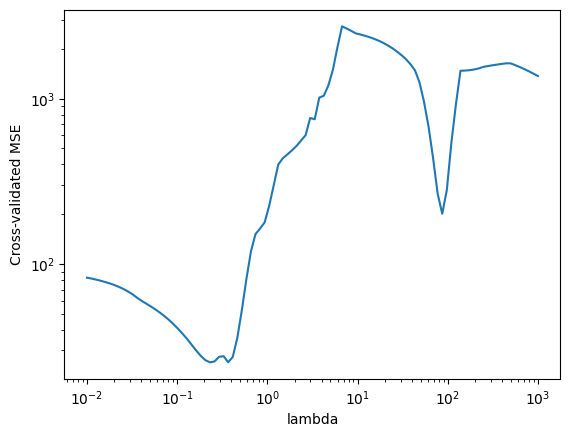

In [31]:
#visulization
# Creates and saves plot of cross-validated MSE by lambda to show the optimal lambda
plt.clf()
plt.plot(lambdas, MSE)
plt.xscale('log')
plt.yscale('log')
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('Cross-validated MSE')

(f) Now generate a response vector Y according to the model $$Y=\beta_{0} + \beta_{7}X^{7} + \epsilon$$ and perform forward stepwise selection and the lasso.

In [32]:
# Generating response vector y as specified in Exercise 8(f)
y = X['X1'].map(lambda x: (5 + 5 * (x ** 7)))  # transforms X to y using an inline function
y = y + epsilon['1']  # Adds normally distributed noise (error term)
print(y)

0     40.952449
1      7.861133
2     -5.027254
3     39.965880
4      8.108034
        ...    
95     1.937749
96     7.268599
97     1.382275
98     0.674328
99     7.506701
Length: 100, dtype: float64


In [33]:
# Constructs empty data frame with just column headers
models_bestsub_f = pd.DataFrame(columns=["RSS", "Model", "var_count", "R^2", "Features"])

# Performs best subset selection
for i in range(1, (len(X.columns)) + 1):
    models_bestsub_f.loc[i] = bestModel(y, X, i)
    models_bestsub_f.loc[i, 'var_count'] = i

# Calculates sigma squared (estimated variance) for each model
m = len(y)
p = 10
hat_sigma_squared = (1 / (m - p - 1)) * models_bestsub_f['RSS'].iloc[len(models_bestsub_f) - 1]

In [34]:
# Manually calculates Cp, BIC, and adjusted R squared and adds each as a column to the models dataframe
models_bestsub_f['C_p'] = (1 / m) * (models_bestsub_f['var_count'].map(lambda x: (2 * x * hat_sigma_squared)) + models_bestsub_f['RSS'])
models_bestsub_f['BIC'] = (models_bestsub_f['RSS'] + np.log(m) * models_bestsub_f['var_count'].map(lambda x: x * hat_sigma_squared)) \
    .map(lambda x: x / (m * hat_sigma_squared))
models_bestsub_f['adj_R^2'] = 1 - ((1 - models_bestsub_f['R^2']) * (m - 1) / (m - models_bestsub_f['var_count'] - 1))

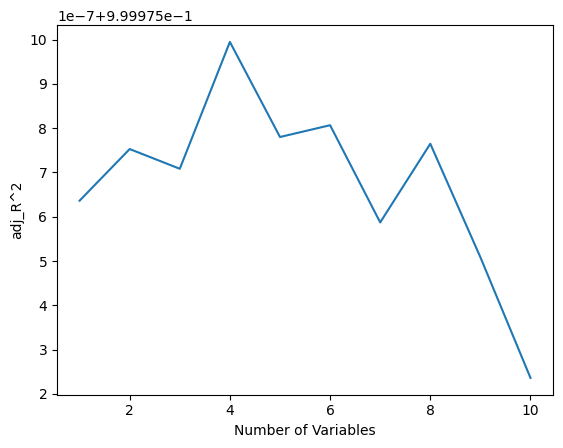

In [35]:
# Creates and saves plots of number of variables by each metric (Cp, BIC, adj R2)
# Note: Scale on y-axis for adjusted R squared plot is incorrect
for response in ['C_p', 'BIC', 'adj_R^2']:
    plt.clf()
    plt.plot(models_bestsub_f['var_count'], models_bestsub_f[response])
    plt.xlabel('Number of Variables')
    plt.ylabel(response)

In [36]:
# Selects best model based on Mallow's Cp
best_model_bestsub_f = models_bestsub_f.loc[models_bestsub_f['C_p'].astype('float64').idxmin(), "Model"]
best_features_bestsub_f = models_bestsub_f.loc[models_bestsub_f['C_p'].astype('float64').idxmin(), "Features"]

In [37]:
#rename the outputs
output_var = str(best_features_bestsub_f)
print(output_var)
output = output_var.replace("7", "X7")
print(output)

('X7',)
('XX7',)


In [38]:
#print the outputs
print("The best subset model has features " + str(output) + " based on Mallow's Cp with coefficients " + str(best_model_bestsub_f.coef_))

The best subset model has features ('XX7',) based on Mallow's Cp with coefficients [4.99529746]


In [39]:
# Constructs empty list in preparation for future MSE values
MSE = []

# This loop performs Lasso with cross-validation for each lambda in our grid defined above
for l in lambdas:
    lasso.set_params(alpha=l)
    currentLambdaMSE = []
    for i in range(10):
        _X_train, _X_test = KFCVSplit(X, 10, i)
        _y_train, _y_test = KFCVSplit(y, 10, i)
        lasso.fit(_X_train, _y_train)
        currentLambdaMSE.append(mean_squared_error(lasso.predict(_X_test), _y_test))
    MSE.append(np.mean(currentLambdaMSE))

MSEDF = pd.DataFrame(MSE)

# Determines the lambda which produced the smallest average MSE - this is the optimal lambda
minLambda = lambdas[MSEDF.idxmin()][0]

# Sets penalty term to the optimal lambda and performs lasso on the entire dataset
lasso.set_params(alpha=minLambda)
lasso.fit(X, y)
print("Lasso parameters (in order of ascending power of X): " + str(lasso.coef_))

Lasso parameters (in order of ascending power of X): [-0.          0.         -3.01863274 -4.91302626  4.69717681  2.17521899
  3.20595875 -0.1290347   0.20004706 -0.02399016]


Text(0, 0.5, 'Cross-validated MSE')

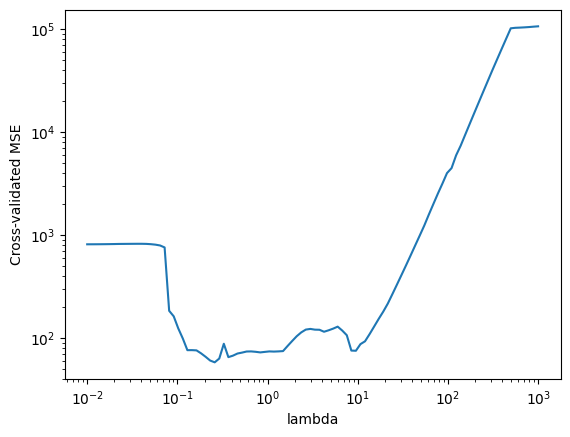

In [40]:
#Visualization
plt.clf()
plt.plot(lambdas, MSE)
plt.xscale('log')
plt.yscale('log')
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('Cross-validated MSE')